In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12

# Show less scientific notation when displaying pandas
pd.set_option("display.float_format", lambda x: f"{x:0.6f}")

In [2]:
tables_dir = os.path.join("..", "results", "tables")
csv_path = os.path.join(tables_dir, "exp12_shape_texture_pier_separated.csv")

df = pd.read_csv(csv_path)
print(f"Loaded shape/texture PIER table from: {csv_path}")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nUnique shape variants:", df["ShapeVariant"].unique())
print("Unique contexts:", df["ContextLabel"].unique())
print("Unique target models:", df["TargetModel"].unique())


Loaded shape/texture PIER table from: ../results/tables/exp12_shape_texture_pier_separated.csv
  ContextType     ContextLabel        TargetModel             Group     Dose  \
0     dataset  texture_natural           ResNet50      Standard CNN 0.000000   
1     dataset  texture_natural     EfficientNetB0      Standard CNN 0.000000   
2     dataset  texture_natural       ConvNeXtTiny      Standard CNN 0.000000   
3     dataset  texture_natural            ViT_B16      Standard CNN 0.000000   
4     dataset  texture_natural  ShapeResNet50_SIN  Shape-biased CNN 0.000000   

   MeanPIER  StdPIER  NumEvalPoints  NumFitPoints  ContextRawSize ShapeVariant  
0  0.000274 0.000197            400           400             800            A  
1  0.000226 0.000162            400           400             800            A  
2  0.000083 0.000086            400           400             800            A  
3  0.000061 0.000111            400           400             800            A  
4  0.000113 0.00023

In [3]:
model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",          # A: SIN only
    "ShapeResNet50_SININ",        # B: SIN + IN
    "ShapeResNet50_ShapeResNet",  # C: SIN+IN then finetuned on IN
]

variant_order = ["A", "B", "C"]  # ShapeVariant

color_map_models = {
    "ResNet50": "tab:orange",
    "EfficientNetB0": "tab:green",
    "ConvNeXtTiny": "tab:red",
    "ViT_B16": "tab:purple",
    "ShapeResNet50_SIN": "tab:blue",
    "ShapeResNet50_SININ": "tab:brown",
    "ShapeResNet50_ShapeResNet": "tab:pink",
}

color_map_contexts = {
    "texture_natural": "tab:gray",
    "shape_bias": "tab:cyan",
}

pretty_context = {
    "texture_natural": "Natural (texture-rich)",
    "shape_bias": "Shape-biased (cue-conflict)",
}

pretty_variant = {
    "A": "ShapeResNet50_SIN (A: SIN only)",
    "B": "ShapeResNet50_SININ (B: SIN+IN)",
    "C": "ShapeResNet50_ShapeResNet (C: SIN+IN→IN)",
}

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}
    sub["__order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    sub = sub.sort_values("__order")
    sub = sub.drop(columns=["__order"])
    return sub


In [4]:
# Compute δPIER = shape_bias - texture_natural (aggregated by ShapeVariant + TargetModel)
pivot = (
    df.pivot_table(
        index=["ShapeVariant", "TargetModel"],
        columns="ContextLabel",
        values="MeanPIER",
        aggfunc="mean",
    )
    .reset_index()
)

# If both contexts exist, compute the difference
if set(["texture_natural", "shape_bias"]).issubset(pivot.columns):
    pivot["DeltaPIER"] = pivot["shape_bias"] - pivot["texture_natural"]
else:
    print("Warning: missing one of the contexts in pivot table.")

pivot = order_models(pivot)
pivot.head()


ContextLabel,ShapeVariant,TargetModel,shape_bias,texture_natural,DeltaPIER
2,A,ResNet50,0.000405,0.000274,0.000131
7,B,ResNet50,0.000405,0.000274,0.000130
12,C,ResNet50,0.000403,0.000274,0.000129
6,B,EfficientNetB0,0.000354,0.000080,0.000274
11,C,EfficientNetB0,0.000386,0.000226,0.000160


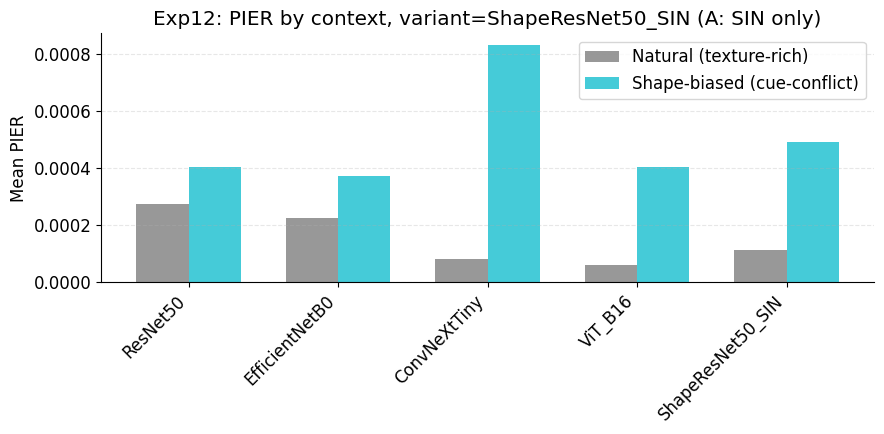

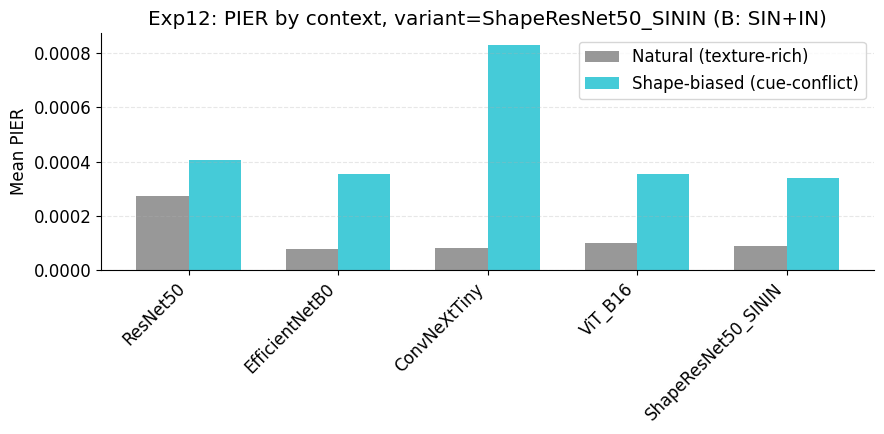

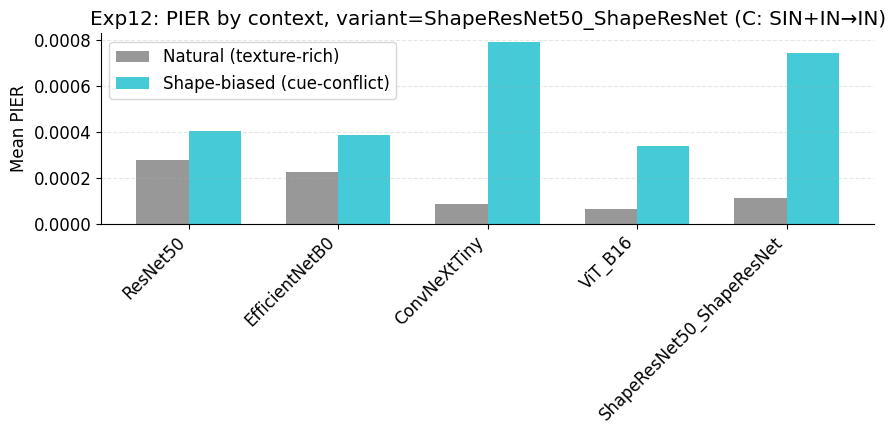

In [5]:
def plot_pier_by_context_for_variant(df: pd.DataFrame, variant: str):
    """对某个 ShapeVariant（A/B/C），画每个模型在两个 context 下的 MeanPIER 对比。"""
    """For a given ShapeVariant (A/B/C), plot MeanPIER by context for each model."""
    sub = df[df["ShapeVariant"] == variant].copy()
    if sub.empty:
        print(f"No rows found for ShapeVariant={variant}")
        return
    
    # Aggregate by model + context (just in case)
    agg = (
        sub.groupby(["TargetModel", "ContextLabel"])["MeanPIER"]
        .mean()
        .reset_index()
    )
    agg = order_models(agg)

    models = agg["TargetModel"].unique().tolist()
    contexts = ["texture_natural", "shape_bias"]
    
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 4.5))

    for i, ctx in enumerate(contexts):
        ctx_data = agg[agg["ContextLabel"] == ctx]
        # Ensure order aligns with models
        ctx_data = ctx_data.set_index("TargetModel").reindex(models)
        heights = ctx_data["MeanPIER"].values

        offset = (-0.5 + i) * width
        ax.bar(
            x + offset,
            heights,
            width=width,
            label=pretty_context.get(ctx, ctx),
            color=color_map_contexts.get(ctx, None),
            alpha=0.8,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_ylabel("Mean PIER")
    ax.set_title(f"Exp12: PIER by context, variant={pretty_variant.get(variant, variant)}")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


for v in variant_order:
    plot_pier_by_context_for_variant(df, v)


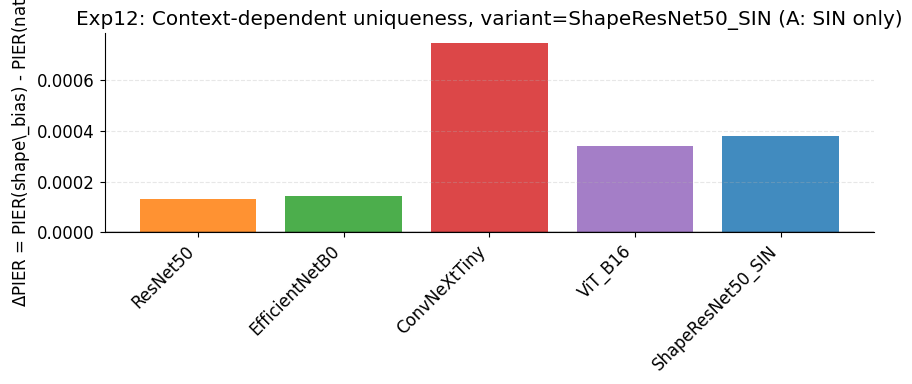

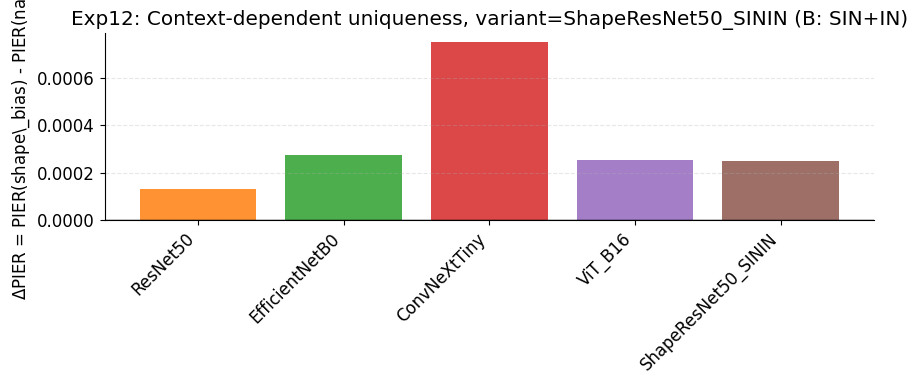

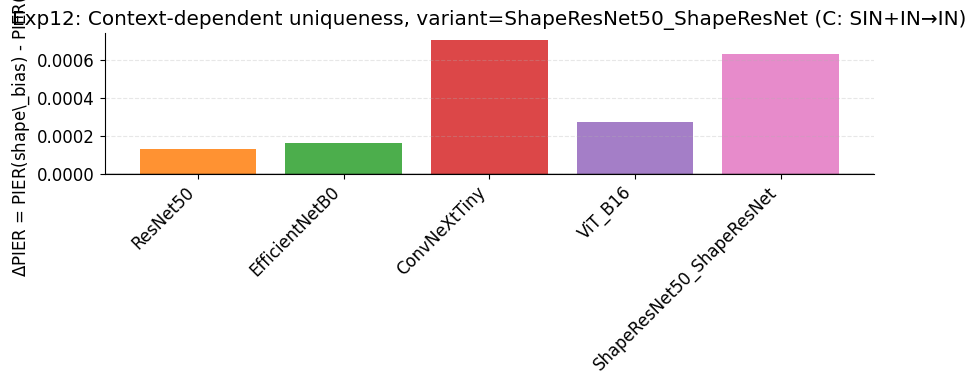

In [6]:
def plot_delta_pier_by_variant(pivot: pd.DataFrame):
    """Using the DeltaPIER from the pivot table above, plot ΔPIER for each model in A/B/C.
       This plot is especially useful to show: who becomes more unique in the shape-biased context.
    """
    if "DeltaPIER" not in pivot.columns:
        print("DeltaPIER not found; run the pivot cell first.")
        return

    for v in variant_order:
        sub = pivot[pivot["ShapeVariant"] == v].copy()
        if sub.empty:
            continue
        sub = order_models(sub)

        models = sub["TargetModel"].tolist()
        deltas = sub["DeltaPIER"].values

        fig, ax = plt.subplots(figsize=(9, 4))
        x = np.arange(len(models))

        colors = [color_map_models.get(m, "tab:gray") for m in models]
        ax.bar(x, deltas, color=colors, alpha=0.85)

        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right")
        ax.set_ylabel(r"$\Delta$PIER = PIER(shape\_bias) - PIER(natural)")
        ax.set_title(f"Exp12: Context-dependent uniqueness, variant={pretty_variant.get(v, v)}")
        ax.axhline(0.0, color="black", linewidth=1)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        plt.tight_layout()
        plt.show()


plot_delta_pier_by_variant(pivot)


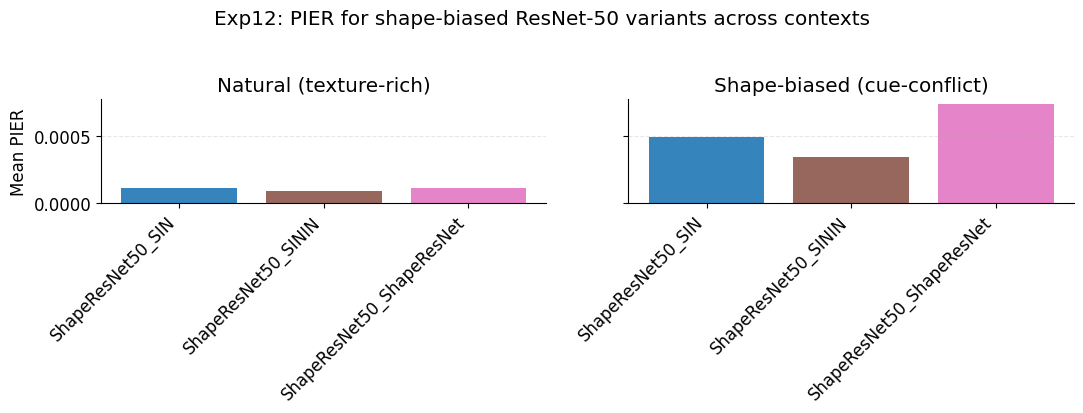

In [7]:
def plot_shape_models_across_variants(df: pd.DataFrame):
    """Focus on the three shape models (A/B/C) and their PIER in natural / shape_bias contexts."""
    shape_names = [
        "ShapeResNet50_SIN",
        "ShapeResNet50_SININ",
        "ShapeResNet50_ShapeResNet",
    ]
    contexts = ["texture_natural", "shape_bias"]

    # Focus on shape models only
    sub = df[df["TargetModel"].isin(shape_names)].copy()
    if sub.empty:
        print("No rows for shape models found.")
        return

    # Aggregate by model + context
    agg = (
        sub.groupby(["TargetModel", "ContextLabel"])["MeanPIER"]
        .mean()
        .reset_index()
    )

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

    for j, ctx in enumerate(contexts):
        ctx_data = agg[agg["ContextLabel"] == ctx].copy()
        ctx_data = order_models(ctx_data)
        models = ctx_data["TargetModel"].tolist()
        vals = ctx_data["MeanPIER"].values

        ax = axes[j]
        x = np.arange(len(models))
        colors = [color_map_models.get(m, "tab:gray") for m in models]
        ax.bar(x, vals, color=colors, alpha=0.9)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right")
        ax.set_title(pretty_context.get(ctx, ctx))
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        if j == 0:
            ax.set_ylabel("Mean PIER")

    fig.suptitle("Exp12: PIER for shape-biased ResNet-50 variants across contexts", y=1.03)
    plt.tight_layout()
    plt.show()


plot_shape_models_across_variants(df)


In [8]:
# Simple summary table: MeanPIER by Variant / Context / Model
summary = (
    df.groupby(["ShapeVariant", "ContextLabel", "TargetModel"])["MeanPIER"]
    .mean()
    .reset_index()
)
summary = order_models(summary)
summary.head(20)


,ShapeVariant,ContextLabel,TargetModel,MeanPIER
2,A,shape_bias,ResNet50,0.000405
7,A,texture_natural,ResNet50,0.000274
12,B,shape_bias,ResNet50,0.000405
17,B,texture_natural,ResNet50,0.000274
22,C,shape_bias,ResNet50,0.000403
27,C,texture_natural,ResNet50,0.000274
11,B,shape_bias,EfficientNetB0,0.000354
6,A,texture_natural,EfficientNetB0,0.000226
21,C,shape_bias,EfficientNetB0,0.000386
1,A,shape_bias,EfficientNetB0,0.000372


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 来自 Geirhos texture-vs-shape 仓库表格的数值
rows = [
    dict(
        Model="ResNet50_IN",
        Label="Standard ResNet-50",
        ShapeBias=21.39,
        Top1=76.13,
    ),
    dict(
        Model="ShapeResNet50_SIN",
        Label="ResNet-50 (SIN only, A)",
        ShapeBias=81.37,
        Top1=60.18,
    ),
    dict(
        Model="ShapeResNet50_SININ",
        Label="ResNet-50 (SIN+IN, B)",
        ShapeBias=34.65,
        Top1=74.59,
    ),
    dict(
        Model="ShapeResNet50_ShapeResNet",
        Label="Shape-ResNet-50 (C)",
        ShapeBias=20.54,
        Top1=76.72,
    ),
]

df_shape_top1 = pd.DataFrame(rows)
df_shape_top1


,Model,Label,ShapeBias,Top1
0,ResNet50_IN,Standard ResNet-50,21.390000,76.130000
1,ShapeResNet50_SIN,"ResNet-50 (SIN only, A)",81.370000,60.180000
2,ShapeResNet50_SININ,"ResNet-50 (SIN+IN, B)",34.650000,74.590000
3,ShapeResNet50_ShapeResNet,Shape-ResNet-50 (C),20.540000,76.720000


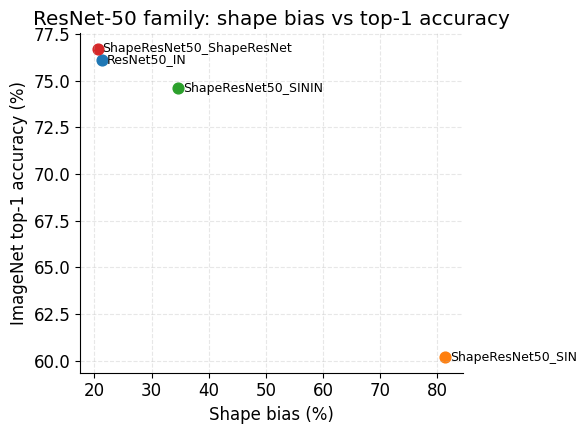

In [10]:
# 画 x = shape bias, y = top-1 accuracy 的散点图
fig, ax = plt.subplots(figsize=(6, 4.5))

for _, row in df_shape_top1.iterrows():
    ax.scatter(row["ShapeBias"], row["Top1"], s=60)
    ax.text(
        row["ShapeBias"] + 0.8,
        row["Top1"],
        row["Model"],
        fontsize=9,
        va="center",
    )

ax.set_xlabel("Shape bias (%)")
ax.set_ylabel("ImageNet top-1 accuracy (%)")
ax.set_title("ResNet-50 family: shape bias vs top-1 accuracy")

ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
rows = [
    dict(Model="ResNet50_IN",         ShapeBias=21.39, Top1=76.13,  DeltaPIER=1.32e-4),
    dict(Model="ShapeResNet50_SIN",   ShapeBias=81.37, Top1=60.18,  DeltaPIER=3.44e-4),
    dict(Model="ShapeResNet50_SININ", ShapeBias=34.65, Top1=74.59,  DeltaPIER=2.28e-4),
    dict(Model="ShapeResNet50_C",     ShapeBias=20.54, Top1=76.72,  DeltaPIER=6.66e-4),
]
df_res = pd.DataFrame(rows)


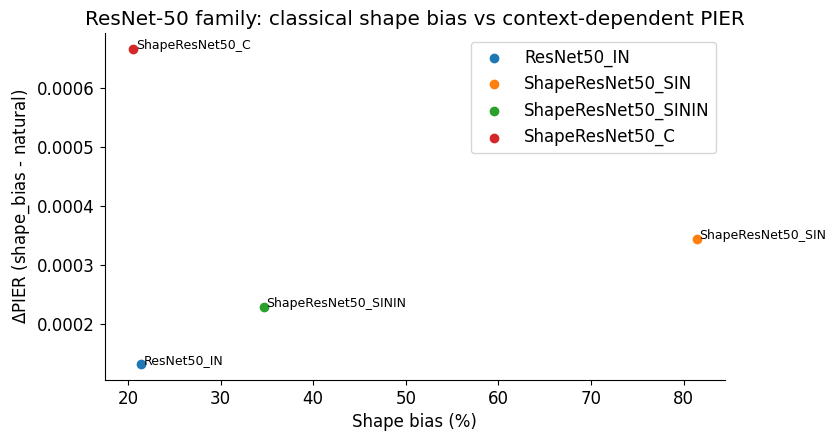

In [12]:
fig, ax = plt.subplots()
for _, row in df_res.iterrows():
    ax.scatter(row["ShapeBias"], row["DeltaPIER"], label=row["Model"])
    ax.text(row["ShapeBias"]+0.3, row["DeltaPIER"], row["Model"], fontsize=9)

ax.set_xlabel("Shape bias (%)")
ax.set_ylabel(r"$\Delta$PIER (shape_bias - natural)")
ax.set_title("ResNet-50 family: classical shape bias vs context-dependent PIER")
plt.legend()
plt.show()


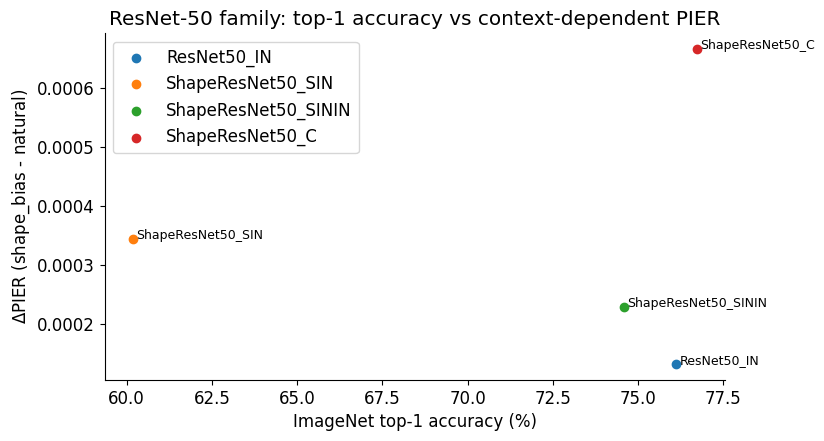

In [13]:
fig, ax = plt.subplots()
for _, row in df_res.iterrows():
    ax.scatter(row["Top1"], row["DeltaPIER"], label=row["Model"])
    ax.text(row["Top1"]+0.1, row["DeltaPIER"], row["Model"], fontsize=9)

ax.set_xlabel("ImageNet top-1 accuracy (%)")
ax.set_ylabel(r"$\Delta$PIER (shape_bias - natural)")
ax.set_title("ResNet-50 family: top-1 accuracy vs context-dependent PIER")
plt.legend()
plt.show()


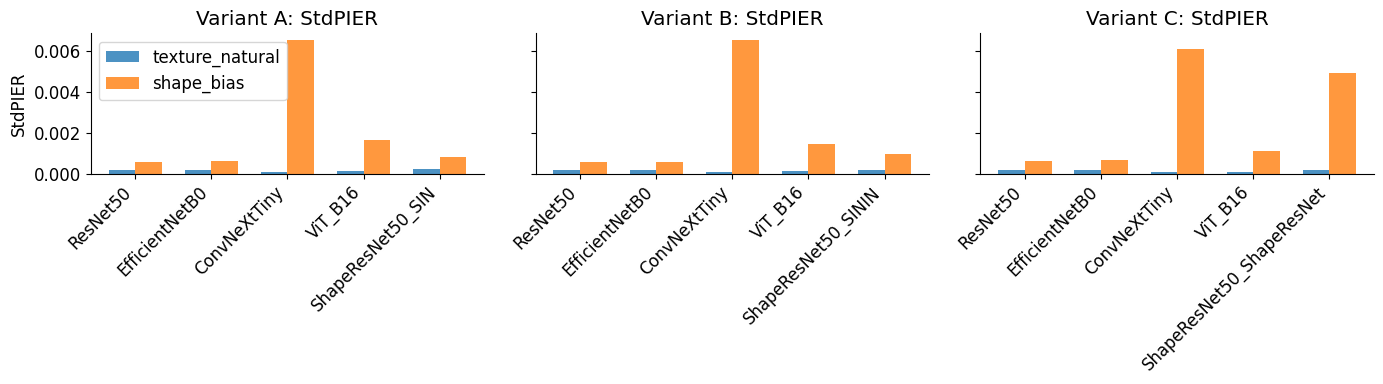

In [14]:
variant_order = ["A", "B", "C"]

model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}
    sub["__order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    return sub.sort_values("__order").drop(columns=["__order"])


fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for ax, v in zip(axes, variant_order):
    sub = df[df["ShapeVariant"] == v]
    if sub.empty:
        ax.set_visible(False)
        continue

    std_pivot = (
        sub.groupby(["TargetModel", "ContextLabel"])["StdPIER"]
        .mean()
        .reset_index()
    )
    std_pivot = order_models(std_pivot)

    models = std_pivot["TargetModel"].unique().tolist()
    x = np.arange(len(models))
    width = 0.35

    for i, ctx in enumerate(["texture_natural", "shape_bias"]):
        ctx_sub = std_pivot[std_pivot["ContextLabel"] == ctx].set_index("TargetModel").reindex(models)
        heights = ctx_sub["StdPIER"].values
        ax.bar(x + (i - 0.5) * width, heights, width=width, label=ctx if v == "A" else None, alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_title(f"Variant {v}: StdPIER")

axes[0].set_ylabel("StdPIER")
axes[0].legend()
plt.tight_layout()
plt.show()


Saved: ../results/figures/decoupling.pdf


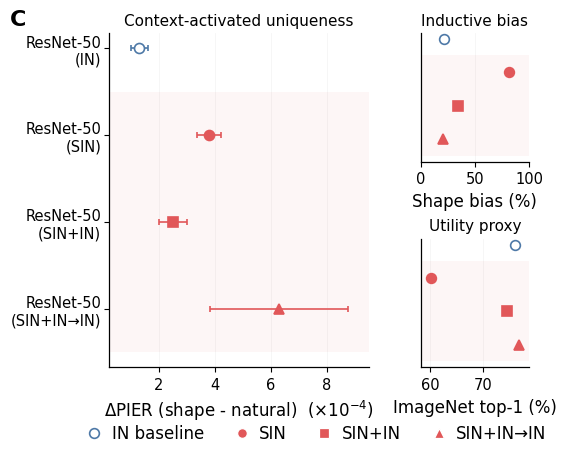

In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def plot_fig4C_decoupling_left_delta_right_bias_utility(
    df12: pd.DataFrame,
    save_path: str = None,
    use_sem: bool = True,
):
    """
    Fig.4C (recommended layout):
      - Left (big): DeltaPIER = PIER(shape_bias) - PIER(texture_natural) with error bars.
      - Right-top: Shape bias (%) for the same lineage models.
      - Right-bottom: ImageNet top-1 (%) for the same lineage models.

    Key message:
      DeltaPIER (ecosystem replaceability shift) is not equivalent to a single scalar
      of inductive bias or utility.

    Error bars:
      - If use_sem=True: ±1 s.e.m. (StdPIER / sqrt(NumEvalPoints))
      - Else: ±95% CI (1.96 * s.e.m.)
    """

    # -------------------------
    # Validate schema (Exp12)
    # -------------------------
    req = {"ContextLabel", "TargetModel", "Dose", "MeanPIER", "StdPIER", "NumEvalPoints", "ShapeVariant"}
    missing = req - set(df12.columns)
    if missing:
        raise ValueError(f"Missing columns {missing}. Found: {list(df12.columns)}")

    NAT = "texture_natural"
    SHP = "shape_bias"

    dff = df12.copy()
    dff["Dose"] = dff["Dose"].astype(float)
    dff = dff[np.isclose(dff["Dose"], 0.0)].copy()
    dff = dff[dff["ContextLabel"].isin([NAT, SHP])].copy()

    # Per-row SEM of the mean PIER (across eval examples)
    n = dff["NumEvalPoints"].astype(float).clip(lower=1.0)
    dff["sem_mean"] = dff["StdPIER"].astype(float) / np.sqrt(n)

    # -------------------------
    # Lineage models to focus on (controlled ResNet-50 training lineage)
    # -------------------------
    lineage_map = {
        "ResNet50": "IN",
        "ShapeResNet50_SIN": "SIN",
        "ShapeResNet50_SININ": "SIN+IN",
        "ShapeResNet50_ShapeResNet": "SIN+IN→IN",
    }
    dff = dff[dff["TargetModel"].isin(lineage_map.keys())].copy()
    dff["Lineage"] = dff["TargetModel"].map(lineage_map)

    # Publication-friendly names for y-axis
    pretty_map = {
        "IN": "ResNet-50\n(IN)",
        "SIN": "ResNet-50\n(SIN)",
        "SIN+IN": "ResNet-50\n(SIN+IN)",
        "SIN+IN→IN": "ResNet-50\n(SIN+IN→IN)",
    }

    # -------------------------
    # Aggregate (some targets may appear under multiple ShapeVariant ecosystems)
    # We average the means; for SEM we use RMS across rows to avoid over-shrinking
    # (rows share the same eval set, so they are not independent samples).
    # -------------------------
    def rms(x: pd.Series) -> float:
        x = np.asarray(x, dtype=float)
        return float(np.sqrt(np.mean(np.square(x))))

    agg = (
        dff.groupby(["TargetModel", "Lineage", "ContextLabel"], as_index=False)
           .agg(
               MeanPIER=("MeanPIER", "mean"),
               SEM=("sem_mean", rms),
           )
    )

    nat = agg[agg["ContextLabel"] == NAT].rename(columns={"MeanPIER": "pier_nat", "SEM": "sem_nat"})[
        ["TargetModel", "Lineage", "pier_nat", "sem_nat"]
    ]
    shp = agg[agg["ContextLabel"] == SHP].rename(columns={"MeanPIER": "pier_shp", "SEM": "sem_shp"})[
        ["TargetModel", "Lineage", "pier_shp", "sem_shp"]
    ]

    wide = pd.merge(nat, shp, on=["TargetModel", "Lineage"], how="inner")

    # DeltaPIER and its SEM (propagation; independence between contexts is a reasonable approximation)
    wide["delta"] = wide["pier_shp"] - wide["pier_nat"]
    wide["sem_delta"] = np.sqrt(wide["sem_nat"]**2 + wide["sem_shp"]**2)

    # Convert SEM to 95% CI if requested
    if not use_sem:
        wide["err_delta"] = 1.96 * wide["sem_delta"]
        err_label = "95% CI"
    else:
        wide["err_delta"] = wide["sem_delta"]
        err_label = "±1 s.e.m."

    # -------------------------
    # External reference metrics (edit to your final numbers)
    # -------------------------
    METRICS = pd.DataFrame([
        {"Lineage": "IN",        "ShapeBias": 21.39, "Top1": 76.13},
        {"Lineage": "SIN",       "ShapeBias": 81.37, "Top1": 60.18},
        {"Lineage": "SIN+IN",    "ShapeBias": 34.65, "Top1": 74.59},
        {"Lineage": "SIN+IN→IN", "ShapeBias": 20.54, "Top1": 76.72},
    ])

    plot_df = pd.merge(wide, METRICS, on="Lineage", how="inner")
    if plot_df.empty:
        raise ValueError("No overlap between Exp12 lineage models and METRICS table.")

    # Order by training lineage
    lineage_order = ["IN", "SIN", "SIN+IN", "SIN+IN→IN"]
    plot_df["rank"] = plot_df["Lineage"].apply(lambda s: lineage_order.index(s))
    plot_df = plot_df.sort_values("rank").reset_index(drop=True)
    plot_df["ModelPretty"] = plot_df["Lineage"].map(pretty_map)

    # Scale DeltaPIER for readability (your magnitudes are ~1e-4)
    SCALE = 1e4  # show values in x 1e-4
    plot_df["delta_s"] = plot_df["delta"] * SCALE
    plot_df["err_delta_s"] = plot_df["err_delta"] * SCALE

    # -------------------------
    # Style (Nature-like muted palette)
    # -------------------------
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    C_BASE  = "#4E79A7"   # muted blue
    C_SHAPE = "#E15759"   # muted red

    marker_map = {"IN": "o", "SIN": "o", "SIN+IN": "s", "SIN+IN→IN": "^"}

    # -------------------------
    # Layout: left big + right stacked small
    # -------------------------
    fig = plt.figure(figsize=(5.6, 4.4))
    gs = GridSpec(
        2, 2,
        width_ratios=[3.25, 1.35],
        height_ratios=[1.0, 1.0],
        wspace=0.28,
        hspace=0.6,
    )

    axL = fig.add_subplot(gs[:, 0])         # big left (DeltaPIER)
    axR1 = fig.add_subplot(gs[0, 1], sharey=axL)  # right-top (ShapeBias)
    axR2 = fig.add_subplot(gs[1, 1], sharey=axL)  # right-bottom (Top1)

    y = np.arange(len(plot_df))

    # Subtle shading for shape-trained variants (rows 1..end)
    if len(plot_df) > 1:
        axL.axhspan(0.5, len(plot_df)-0.5, color=C_SHAPE, alpha=0.05, lw=0)
        axR1.axhspan(0.5, len(plot_df)-0.5, color=C_SHAPE, alpha=0.05, lw=0)
        axR2.axhspan(0.5, len(plot_df)-0.5, color=C_SHAPE, alpha=0.05, lw=0)

    # Grid (x only, light)
    for ax in [axL, axR1, axR2]:
        ax.grid(True, axis="x", linewidth=0.6, alpha=0.12)
        ax.set_axisbelow(True)

    # -------------------------
    # Left: DeltaPIER with error bars
    # -------------------------
    for i, row in plot_df.iterrows():
        lineage = row["Lineage"]
        mk = marker_map.get(lineage, "o")
        c = C_BASE if lineage == "IN" else C_SHAPE
        mfc = "white" if lineage == "IN" else c

        axL.errorbar(
            row["delta_s"], i, xerr=row["err_delta_s"],
            fmt=mk, ms=7.2,
            mfc=mfc, mec=c, mew=1.2,
            ecolor=c, elinewidth=1.2, capsize=2.2,
            zorder=3
        )

    axL.axvline(0.0, color="0.35", lw=0.9, alpha=0.9)
    axL.set_xlabel(r"$\Delta$PIER (shape - natural)  " + r"($\times 10^{-4}$)")
    axL.set_title("Context-activated uniqueness", fontsize=11, pad=6)

    # Y axis labels only on the left panel
    axL.set_yticks(y)
    axL.set_yticklabels(plot_df["ModelPretty"].tolist())
    axL.invert_yaxis()
    axL.tick_params(axis="y", pad=2)

    # Small note about uncertainty type (SEM vs CI)
    # axL.text(
    #     0.02, 0.02, 
    #     f"Error bars: {err_label}",
    #     transform=axL.transAxes,
    #     fontsize=10.0, color="0.30",
    #     ha="left", va="bottom"
    # )

    # Tight x-lims to avoid emptiness
    x_min = float((plot_df["delta_s"] - plot_df["err_delta_s"]).min())
    x_max = float((plot_df["delta_s"] + plot_df["err_delta_s"]).max())
    pad = 0.10 * (x_max - x_min + 1e-12)
    axL.set_xlim(x_min - pad, x_max + pad)

    # -------------------------
    # Right-top: Shape bias (%)
    # -------------------------
    for i, row in plot_df.iterrows():
        lineage = row["Lineage"]
        mk = marker_map.get(lineage, "o")
        c = C_BASE if lineage == "IN" else C_SHAPE
        mfc = "white" if lineage == "IN" else c

        axR1.plot(
            row["ShapeBias"], i,
            marker=mk, ms=7.0,
            mfc=mfc, mec=c, mew=1.2,
            linestyle="None", zorder=3
        )

    axR1.set_title("Inductive bias", fontsize=11, pad=6)
    axR1.set_xlabel("Shape bias (%)")
    axR1.set_xlim(0, 100)
    axR1.tick_params(axis="y", left=False, labelleft=False)

    # -------------------------
    # Right-bottom: Top-1 (%)
    # -------------------------
    for i, row in plot_df.iterrows():
        lineage = row["Lineage"]
        mk = marker_map.get(lineage, "o")
        c = C_BASE if lineage == "IN" else C_SHAPE
        mfc = "white" if lineage == "IN" else c

        axR2.plot(
            row["Top1"], i,
            marker=mk, ms=7.0,
            mfc=mfc, mec=c, mew=1.2,
            linestyle="None", zorder=3
        )

    axR2.set_title("Utility proxy", fontsize=11, pad=6)
    axR2.set_xlabel("ImageNet top-1 (%)")

    # Tight x-lims (prevents the "empty" look)
    tmin = float(plot_df["Top1"].min())
    tmax = float(plot_df["Top1"].max())
    tpad = 0.12 * (tmax - tmin + 1e-12)
    axR2.set_xlim(tmin - tpad, tmax + tpad)
    axR2.tick_params(axis="y", left=False, labelleft=False)

    # -------------------------
    # Compact legend (marker semantics)
    # -------------------------
    handles = [
        Line2D([0], [0], marker="o", color="none", label="IN baseline",
               markerfacecolor="white", markeredgecolor=C_BASE, markeredgewidth=1.2, markersize=7),
        Line2D([0], [0], marker="o", color="none", label="SIN",
               markerfacecolor=C_SHAPE, markeredgecolor="white", markeredgewidth=0.9, markersize=7),
        Line2D([0], [0], marker="s", color="none", label="SIN+IN",
               markerfacecolor=C_SHAPE, markeredgecolor="white", markeredgewidth=0.9, markersize=7),
        Line2D([0], [0], marker="^", color="none", label="SIN+IN→IN",
               markerfacecolor=C_SHAPE, markeredgecolor="white", markeredgewidth=0.9, markersize=7),
    ]
    axR2.legend(handles=handles, frameon=False, 
                fontsize=12, loc="lower right", 
                bbox_to_anchor=(1.3, -0.7),ncol=4,handlelength=0.5)

    fig.subplots_adjust(left=0.19, right=0.94, top=0.94, bottom=0.18)
    axL.text(-3.8, 2.63, "C", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")


    if save_path is not None:
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


tables_dir = os.path.join("..", "results", "tables")
df12 = pd.read_csv(os.path.join(tables_dir, "exp12_shape_texture_pier_separated.csv"))

plot_fig4C_decoupling_left_delta_right_bias_utility(
    df12,
    save_path=os.path.join("..", "results", "figures", "decoupling.pdf"),
    use_sem=True,  # True = SEM; False = 95% CI
);
